# Notebook Imports

In [107]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np
%matplotlib inline

# Constants

In [153]:
EXAMPLE_FILE = "SpamData/01_Processing/practice_email.txt"
SPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "SpamData/01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "SpamData/01_Processing/email-text-data.json"
WORD_ID_FILE = "SpamData/01_Processing/word-by-id.csv"
WHALE_FILE = "SpamData/01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE = "SpamData/01_Processing/wordcloud_resources/skull-icon.png"
THUMBS_UP_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-up.png"
THUMBS_DOWN_FILE = "SpamData/01_Processing/wordcloud_resources/thumbs-down.png"
OPENSANS_BOLD_FILE = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf"
OPENSANS_LIGHT_FILE = "SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Light.ttf"

# Reading Files

In [4]:
stream = open(EXAMPLE_FILE, encoding = "latin-1")
message = stream.read()
stream.close()
#print(type(message))
#print(message)

In [5]:
#import sys
#sys.getfilesystemencoding()

In [6]:
stream = open(EXAMPLE_FILE, encoding = "latin-1")
is_body = False
lines = []
for line in stream:
    if is_body:
        lines.append(line)
    elif line == "\n":
        is_body = True
stream.close()

email_body = "\n".join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [7]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [8]:
for i in generate_squares(5):
    print(i, end = "->")

0->1->4->9->16->

# Email body extraction

In [9]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            stream = open(filepath, encoding = "latin-1")
            is_body = False
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == "\n":
                    is_body = True
            stream.close()

            email_body = "\n".join(lines)
            yield file_name, email_body

In [10]:
def df_from_directory(path, classification):
    rows= []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({"MESSAGE": email_body, "CATEGORY": classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index = row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()
#spam_emails.shape

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.head()
ham_emails.shape

(3901, 2)

In [13]:
data = pd.concat([spam_emails, ham_emails])
print("Shape of entire dataframe is: ", data.shape)
data.head()

Shape of entire dataframe is:  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [14]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing Values

In [15]:
# check if any message bodies are null
data["MESSAGE"].isnull().values.any()
(data.MESSAGE.isnull() == True).sum()
(data.MESSAGE.isnull()).sum()

0

In [16]:
# check if there are empty emails ( string length zero)
data.MESSAGE.str.len().values.any()
(data.MESSAGE.str.len() == 0).sum()

3

## Locate empty emails

In [17]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [18]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [19]:
data.index.get_loc("cmds")
data[4608 : 4611]

,MESSAGE,CATEGORY
00210.ca401834d76bbedb98e548160e2ab559,I have a strange problem with one user in a sm...,0
00211.835ec23b746b6aede4e2e15ced421bb4,"I just heard from Kevin Patrick Scannell, auth...",0
00212.df5211161d938a2547804a50f0a8698f,"At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...",0


# Remove System File Entries from Dataframe

In [20]:
data.drop(["cmds"], inplace = True)

In [21]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [22]:
document_ids = range(0, len(data.index))
data["DOC_ID"] = document_ids

In [23]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


# Save to File using Pandas

In [24]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [25]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [26]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

In [27]:
#category_names = ["Spam", "Legit Mail"]
#sizes = [amount_of_spam, amount_of_ham]
#plt.figure(figsize = (2,2), dpi = 230)
#plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%")
#plt.show()

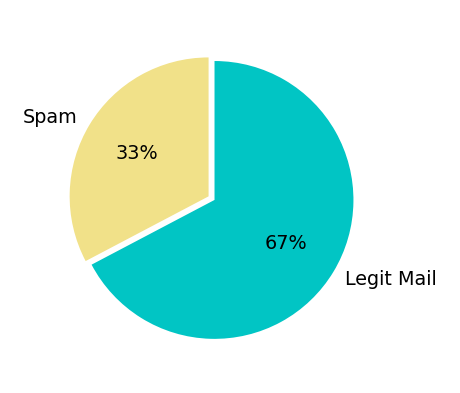

In [28]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#f1e189","#01c5c4"]
plt.figure(figsize = (2,2), dpi = 230)
plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%",
        colors = custom_colours, explode = [0, 0.05])
plt.show()

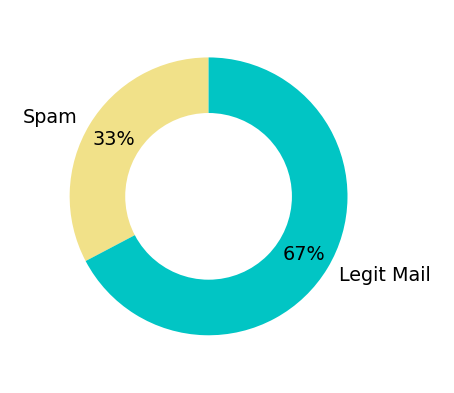

In [29]:
category_names = ["Spam", "Legit Mail"]
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ["#f1e189","#01c5c4"]
plt.figure(figsize = (2,2), dpi = 230)
plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%",
        colors = custom_colours, pctdistance = 0.8)

# draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = "white")
plt.gca().add_artist(centre_circle)
plt.show()

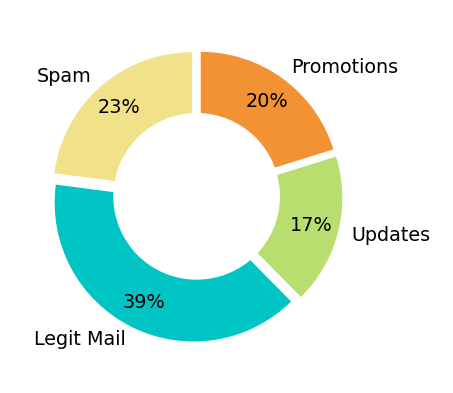

In [30]:
category_names = ["Spam", "Legit Mail", "Updates", "Promotions"]
sizes = [25, 43, 19, 22]
custom_colours = ["#f1e189","#01c5c4","#b8de6f", "#f39233"]
offset = [0.05, 0.05, 0.05, 0.05]
plt.figure(figsize = (2,2), dpi = 230)
plt.pie(sizes, labels = category_names, textprops = {"fontsize" : 6}, startangle = 90, autopct = "%1.0f%%",
        colors = custom_colours, pctdistance = 0.8, explode = offset)

# draw circle
centre_circle = plt.Circle((0,0), radius = 0.6, fc = "white")
plt.gca().add_artist(centre_circle)
plt.show()

# Natural Language Processing

## Text Pre-Processing

In [31]:
msg = "All work and no play makes Jack a dull boy."
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [32]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to C:\Users\Jiacheng
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Jiacheng
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [89]:
nltk.download("gutenberg")
nltk.download("shakespeare")

[nltk_data] Downloading package gutenberg to C:\Users\Jiacheng
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to C:\Users\Jiacheng
[nltk_data]     Li\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [34]:
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing stop words

In [35]:
stop_words = set(stopwords.words("english"))
type(stop_words)

set

In [36]:
msg = "All work and no play makes Jack a dull boy. To be or not to be."
words = word_tokenize(msg.lower())
filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stem and Stemming

In [37]:
msg = "All work and no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inguisition!"
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer("english")

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inguisit', '!']


## Remove Punctuation

In [38]:
msg = "All work and no play makes Jack a dull boy. To be or not to be.??? \
       Nobody expects the Spanish Inguisition!"
words = word_tokenize(msg.lower())
stemmer = SnowballStemmer("english")
filtered_words = []

for word in words:
    if word not in stop_words and word.isalpha() == True:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inguisit']


## Remove HTML tags

In [39]:
soup = BeautifulSoup(data.at[5, "MESSAGE"], "html.parser")
soup.get_text()
#print(soup.prettify())

'A POWERHOUSE GIFTING PROGRAM You Don\'t Want To Miss! \n\n \n\n  GET IN WITH THE FOUNDERS! \n\nThe MAJOR PLAYERS are on This ONE\n\nFor ONCE be where the PlayerS are\n\nThis is YOUR Private Invitation\n\n\n\nEXPERTS ARE CALLING THIS THE FASTEST WAY \n\nTO HUGE CASH FLOW EVER CONCEIVED\n\nLeverage $1,000 into $50,000 Over and Over Again\n\n\n\nTHE QUESTION HERE IS:\n\nYOU EITHER WANT TO BE WEALTHY \n\nOR YOU DON\'T!!!\n\nWHICH ONE ARE YOU?\n\nI am tossing you a financial lifeline and for your sake I \n\nHope you GRAB onto it and hold on tight For the Ride of youR life!\n\n\n\nTestimonials\n\n\n\nHear what average people are doing their first few days:\n\n\x93We\'ve received 8,000 in 1 day and we are doing that over and over again!\' Q.S. in AL\n\n \x93I\'m a single mother in FL and I\'ve received 12,000 in the last 4 days.\x94 D. S. in FL\n\n\x93I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!\x94 L.L. in KY\n\n\x93I didn\'t have the 

## Email Processing Functions

In [40]:
def clean_message(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words("english"))):
    # Convert to lower case then tokenize.
    words = word_tokenize(message.lower())
    filtered_words = []
    # Remove stop words and punctuations.
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [41]:
#clean_message(email_body)

In [42]:
def clean_msg_no_html(message, stemmer = PorterStemmer(), stop_words = set(stopwords.words("english"))):
    # Remove HTML tags.
    message = BeautifulSoup(message, "html.parser").get_text()
    # Convert to lower case then tokenize.
    words = word_tokenize(message.lower())
    filtered_words = []
    # Remove stop words and punctuations.
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [43]:
clean_msg_no_html(data.at[5, "MESSAGE"])

['powerhous',
 'gift',
 'program',
 'want',
 'miss',
 'get',
 'founder',
 'major',
 'player',
 'one',
 'player',
 'privat',
 'invit',
 'expert',
 'call',
 'fastest',
 'way',
 'huge',
 'cash',
 'flow',
 'ever',
 'conceiv',
 'leverag',
 'question',
 'either',
 'want',
 'wealthi',
 'one',
 'toss',
 'financi',
 'lifelin',
 'sake',
 'hope',
 'grab',
 'onto',
 'hold',
 'tight',
 'ride',
 'life',
 'testimoni',
 'hear',
 'averag',
 'peopl',
 'first',
 'day',
 'receiv',
 'day',
 'al',
 'singl',
 'mother',
 'fl',
 'receiv',
 'last',
 'fl',
 'sure',
 'sent',
 'pledg',
 'got',
 'back',
 'next',
 'day',
 'ky',
 'money',
 'found',
 'partner',
 'work',
 'receiv',
 'last',
 'day',
 'think',
 'made',
 'right',
 'decis',
 'fl',
 'pick',
 'first',
 'day',
 'gave',
 'free',
 'lead',
 'train',
 'ca',
 'announc',
 'close',
 'sale',
 'help',
 'get',
 'fax',
 'blast',
 'immedi',
 'upon',
 'entri',
 'make',
 'money',
 'free',
 'lead',
 'train',
 'wait',
 'call',
 'fax',
 'back',
 'call',
 'best',
 'time',
 'me

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [44]:
data.iat[2,0]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [45]:
data.iloc[5 : 11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,Help wanted. We are a 14 year old fortune 500...,1,00007.d8521faf753ff9ee989122f6816f87d7
7,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,1,00008.dfd941deb10f5eed78b1594b131c9266
8,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,1,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",1,00010.445affef4c70feec58f9198cfbc22997
10,Cellular Phone Accessories All At Below Wholes...,1,00011.61816b9ad167657773a427d890d0468e


In [46]:
first_emails = data.MESSAGE.iloc[0 : 3]
nested_list = first_emails.apply(clean_message)
print(type(nested_list))
nested_list

<class 'pandas.core.series.Series'>


DOC_ID
0    [doctyp, html, public, html, html, head, meta,...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object

In [47]:
# Store all words in an email in a list.
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
len(flat_list)

321

In [48]:
%%time
# Use apply() to clean all messages in the DataFrame.
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 30.5 s


In [49]:
nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

### Using Logic to Slice Dataframes

In [50]:
data[data.CATEGORY == 1].shape
data[data.CATEGORY == 0].shape

(3900, 3)

In [51]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subset a Series with an Index

In [52]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [53]:
type(nested_list)

pandas.core.series.Series

In [54]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 3900, dtype: object

In [55]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, Length: 1896, dtype: object

In [63]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]

In [73]:
# Find the most common 10 words.
# from collections import Counter

# def most_common(lst):
#     data = Counter(lst)
#     return data.most_common(10)

# most_common(flat_list_ham)
# most_common(flat_list_spam)

In [77]:
# Count the total number of unique words.
# Find the most common 10 words alternative method.
normal_words = pd.Series(flat_list_ham).value_counts()
print(normal_words.shape[0])
normal_words[:10]

20815


http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [78]:
spammy_words = pd.Series(flat_list_spam).value_counts()
print(spammy_words.shape[0])
spammy_words[:10]

13242


http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Create a Word Cloud

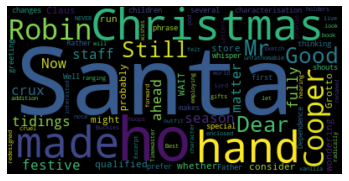

In [86]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [94]:
example_corpus = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
len(example_corpus)
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [100]:
# Convert from corpusView to list then to string
word_list = ["".join(word) for word in example_corpus]
novel_as_string = " ".join(word_list)
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

In [119]:
# icon = Image.open(WHALE_FILE)
# image_mask = Image.new(mode = "RGB", size = icon.size, color = (255, 255, 255))
# image_mask.paste(icon, box = icon)
# rgb_array = np.array(image_mask)
# word_cloud = WordCloud(mask = rgb_array, background_color = "white", max_words = 400, colormap = "ocean").generate(novel_as_string)
# plt.figure(figsize = [16, 8])
# plt.imshow(word_cloud, interpolation = "bilinear")
# plt.axis("off")
# plt.show()

In [111]:
rgb_array.shape

(1024, 2048, 3)

In [112]:
# Below is a white pixel
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [113]:
# Below is a black pixel
rgb_array[500,  1000]

array([0, 0, 0], dtype=uint8)

In [120]:
# example_corpus = nltk.corpus.gutenberg.words("shakespeare-hamlet.txt")

# word_list = ["".join(word) for word in example_corpus]
# novel_as_string = " ".join(word_list)

# icon = Image.open(SKULL_FILE)
# image_mask = Image.new(mode = "RGB", size = icon.size, color = (255, 255, 255))
# image_mask.paste(icon, box = icon)
# rgb_array = np.array(image_mask)
# word_cloud = WordCloud(mask = rgb_array, background_color = "white", max_words = 400, colormap = "bone").generate(novel_as_string)
# plt.figure(figsize = [16, 8])
# plt.imshow(word_cloud, interpolation = "bilinear")
# plt.axis("off")
# plt.show()

# Word Cloud of Ham and Spam Messages

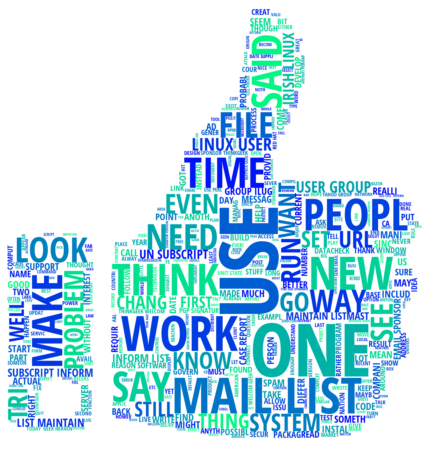

In [138]:
# Masking
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode = "RGB", size = icon.size, color = (255, 255, 255))
image_mask.paste(icon, box = icon)
rgb_array = np.array(image_mask)

# Generate String
ham_str = " ".join(flat_list_ham)
word_cloud = WordCloud(mask = rgb_array, background_color = "white",
                       max_words = 400, font_path = OPENSANS_BOLD_FILE, max_font_size = 300,
                       colormap = "winter").generate(ham_str.upper())
plt.figure(figsize = [16, 8])
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

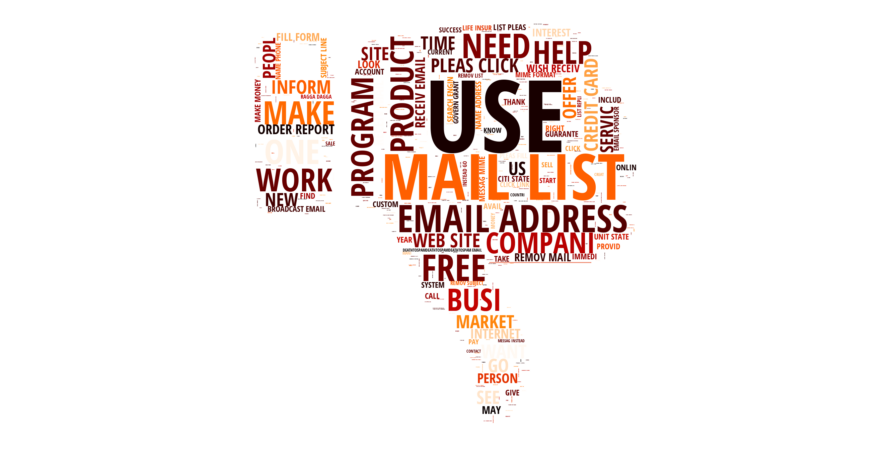

In [136]:
# Masking
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode = "RGB", size = icon.size, color = (255, 255, 255))
image_mask.paste(icon, box = icon)
rgb_array = np.array(image_mask)

# Generate String
ham_str = " ".join(flat_list_spam)
word_cloud = WordCloud(mask = rgb_array, background_color = "white", 
                       max_words = 400, colormap = "gist_heat",
                       font_path = OPENSANS_BOLD_FILE, max_font_size = 300).generate(ham_str.upper())
plt.figure(figsize = [16, 8])
plt.imshow(word_cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# Generate Vocabulary & Dictionary

In [139]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [146]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print("Number of unique words", unique_words.shape[0])
unique_words.head()

Number of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [152]:
# List(Pandas Series) to store the most common 2500 words.
frequent_words = unique_words[0 : VOCAB_SIZE]
print(frequent_words.head(10))

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [158]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({"VOCAB_WORD" : frequent_words.index.values}, index = word_ids)
vocab.index.name = "WORD_ID"
vocab

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get
...,...
2495,leas
2496,realnetwork
2497,gotten


## Save the Vocabulary as a CSV File

In [159]:
vocab.to_csv(WORD_ID_FILE, index_label = "vocab.index.name", header = "vocab.VOCAB_WORD.name")

# Check if a word is part of the vocabulary dataframe

In [164]:
test_words = ["machine", "learning", "fun", "learn", "data", "science", "app", "brewery"]
for word in test_words:
    if vocab['VOCAB_WORD'].str.contains(word).any():
        print("True for", word)
    else:
        print("False for", word)

False for machine
False for learning
True for fun
True for learn
True for data
False for science
True for app
False for brewery


In [165]:
# Alternative approach (using sets)
"machine" in set(vocab.VOCAB_WORD)

False

# Find the longest email (most words)

In [219]:
count = []
for i in range (0, len(stemmed_nested_list)):
    count.append(len(stemmed_nested_list[i]))
max_index = count.index(max(count))
print("Number of words in the longest email:", max(count))
print("Position:", max_index)
print(stemmed_nested_list[max_index])
print(data["MESSAGE"][max_index])

Number of words in the longest email: 7671
Position: 5775
['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', 'synchron', 'run', 'osx', 'switch', 'treatment', '

In [221]:
# Alternative Approach 1
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))
# Alternative Approach 2
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
# Alternative way to find index in a np array
np.argmax(clean_email_lengths)
# Alternative way to pick the message from the dataframe
#data.at[np.argmax(clean_email_lengths), "MESSAGE"]

5775